In [3]:
""" Source: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
 In this task, rewards are +1 for every incremental timestep and the environment terminates
 if the pole falls over too far or the cart moves more then 2.4 units away from center"""

' Source: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html\n In this task, rewards are +1 for every incremental timestep and the environment terminates\n if the pole falls over too far or the cart moves more then 2.4 units away from center'

In [5]:
conda install pytorch torchvision cudatoolkit=10.1 -c pytorch

Solving environment: done

## Package Plan ##

  environment location: /home/manav/anaconda3

  added / updated specs:
    - cudatoolkit=10.1
    - pytorch
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |             main           3 KB
    conda-4.8.0                |           py37_1         3.0 MB
    conda-package-handling-1.6.0|   py37h7b6447c_0         872 KB
    cudatoolkit-10.1.243       |       h6bb024c_0       513.2 MB
    ninja-1.9.0                |   py37hfd86e86_0         1.6 MB
    pytorch-1.3.1              |py3.7_cuda10.1.243_cudnn7.6.3_0       428.0 MB  pytorch
    torchvision-0.4.2          |       py37_cu101        14.9 MB  pytorch
    ------------------------------------------------------------
                                           Total:       961.6 MB

The following NEW packages will be INSTALLED:

  _libgcc_mute

In [5]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
env = gym.make('CartPole-v0').unwrapped

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
"""
    Transition - a named tuple representing a single transition in our environment. It essentially maps (state, action) pairs to their (next_state, reward) result, with the state being the screen difference image as described later on.
    ReplayMemory - a cyclic buffer of bounded size that holds the transitions observed recently. It also implements a .sample() method for selecting a random batch of transitions for training.
"""

'\n    Transition - a named tuple representing a single transition in our environment. It essentially maps (state, action) pairs to their (next_state, reward) result, with the state being the screen difference image as described later on.\n    ReplayMemory - a cyclic buffer of bounded size that holds the transitions observed recently. It also implements a .sample() method for selecting a random batch of transitions for training.\n'

In [9]:
Transition = namedtuple('Transition',('state','action','next_state','reward'))
class ReplayMemory(object):
    def __init__(self,capacity):
        self.capacity=capacity
        self.memory=[]
        self.position=0
    def push(self,*args):
        #Saves a transtion
        if len(self.memory)<self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position+1) % self.capacity
    def sample(self, batch_size):
            return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

In [18]:
class DQN(nn.Module):
    def __init__(self,h,w,outputs):
        super(DQN, self).__init__()
        self.conv1=nn.Conv2d(3,16,kernel_size=5,stride=2)
        self.bn1=nn.BatchNorm2d(16)
        self.conv2=nn.Conv2d(16,32,kernel_size=5,stride=2)
        self.bn2=nn.BatchNorm2d(32)
        self.conv3=nn.Conv2d(32,32,kernel_size=5, stride=2)
        self.bn3=nn.BatchNorm2d(32)
        
        def conv2d_size_out(size,kernel_size=5, stride=2):
            return (size-(kernel_size-1) - 1)//stride + 1
        convw=conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh=conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size=convw*convh*32
        self.head=nn.Linear(linear_input_size,outputs)
    
    def forward(self,x):
        x=F.relu(self.bn1(self.conv1(x)))
        x=F.relu(self.bn2(self.conv2(x)))
        x=F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0),-1))

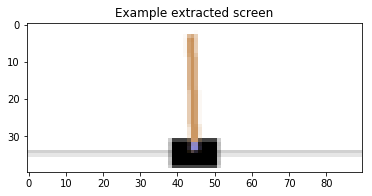

In [19]:
resize=T.Compose([T.ToPILImage(), T.Resize(40, interpolation=Image.CUBIC), T.ToTensor()])
def get_cart_location(screen_width):
    world_width=env.x_threshold*2
    scale=screen_width/world_width
    return int(env.state[0]*scale+screen_width/2.0)
def get_screen():
    screen=env.render(mode='rgb_array').transpose((2,0,1))
    _,screen_height,screen_width=screen.shape
    screen=screen[:,int(screen_height*.4):int(screen_height*.8)]
    view_width=int(screen_width*.6)
    cart_location=get_cart_location(screen_width)
    if cart_location<view_width//2:
        slice_range=slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range=slice(-view_width,None)
    else:
        slice_range=slice(cart_location-view_width//2, cart_location+view_width//2)
    screen=screen[:,:,slice_range]
    screen=np.ascontiguousarray(screen, dtype=np.float32)/255
    screen=torch.from_numpy(screen)
    return resize(screen).unsqueeze(0).to(device)
env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1,2,0).numpy(),interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [33]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
init_screen=get_screen()
_,_,screen_height,screen_width=init_screen.shape
n_actions=env.action_space.n
policy_net=DQN(screen_height,screen_width,n_actions).to(device)
target_net=DQN(screen_height,screen_width,n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer=optim.RMSprop(policy_net.parameters())
memory=ReplayMemory(10000)

steps_done=0

def  select_action(state):
    global steps_done
    sample=random.random()
    eps_threshold =EPS_END + (EPS_START - EPS_END)*\
        math.exp(-1.*steps_done/EPS_DECAY)
    steps_done+=1
    if sample>eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1,1)
    else:
        return torch.tensor([[random.randrange(n_actions)]],device=device,dtype=torch.long)
episode_durations=[]

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t=torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training..')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    if len(durations_t)>=100:
        means=durations_t.unfold(0,100,1).mean(1).view(-1)
        means=torch.cat((torch.zeros(99),means))
        plt.plot(means.numpy())
        
    plt.pause(.001)
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())
        

In [34]:
def optimize_model():
    if len(memory)<BATCH_SIZE:
        return
    transitions=memory.sample(BATCH_SIZE)
    #This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))
    non_final_mask=torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states=torch.cat([s for s in batch.next_state if s is not None])
    state_batch=torch.cat(batch.state)
    action_batch=torch.cat(batch.action)
    reward_batch=torch.cat(batch.reward)

    state_action_values=policy_net(state_batch).gather(1,action_batch)
    
    next_state_values=torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask]=target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values=(next_state_values*GAMMA)+reward_batch
    
    loss=F.smooth_l1_loss(state_action_values,expected_state_action_values.unsqueeze(1))
    
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1,1)
    optimizer.step()
    

In [35]:
num_episodes=50
for i_episode in range(num_episodes):
    env.reset()
    last_screen=get_screen()
    current_screen=get_screen()
    state=current_screen-last_screen
    for t in count():
        action=select_action(state)
        _,reward,done,_=env.step(action.item())
        reward=torch.tensor([reward],device=device)
        
        last_screen=current_screen
        current_screen=get_screen()
        if not done:
            next_state=current_screen-last_screen
        else:
            next_state=None
            
        memory.push(state,action,next_state,reward)
        
        state=next_state
        
        optimize_model()
        if done:
            episode_durations.append(t+1)
            plot_durations()
            break
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

<Figure size 432x288 with 0 Axes>

Complete


<Figure size 432x288 with 0 Axes>